# Segregating Player Performance: Which NBA players are most alike?

## Executive Summary
In this study, our sub-learning team explored clustering NBA players according to their statistics posted on Basketball-Reference.com. We scraped the website for NBA Playoffs statistics per player for the years 1989, 1999, 2009, and 2019. The statistics per Playoff year were transformed into a dataset ready for clustering, and analyzed by bringing together key datapoints per year using data wrangling techniques in Python.

A clustering process was implemented for the Playoffs data for each year of 1989, 1999, 2009, and 2019:

- We implemented a Standard Scaler to normalize the data and make it easy for clustering<br>
- The dimensionality of the dataset was reduced using Principal Component Analysis (PCA)<br>
- K-means clustering algorithm was used to cluster the data <br>
- Using the standard internal validation criteria, we were able to determine there are three appropriate clusters of NBA players per year of the scraped Playoffs data.<br>

The resulting three clusters per year resulted to segregation of players based on their performances regardless of their team.

In the three clusters, the **`standouts`** are the top performing players with the highest average number of points made throughout the playoffs, the **`regulars`** are the mid-tier players who don't have quite as good contributing numbers compared to the former, and lastly, the **`mediocres`** are the worst of the Playoffs performers regardless of the team.

We were able to gain insights on the differences of the "winning statistics" in four different eras of the NBA by selecting the average statistics per "standout" cluster of each year and comparing it to the others. From 1989 to 2019, the aggregated data from clustering suggests that the style of playing has progressively increased in being "top player-centric" which reflects the business environment of the NBA. The three-point shooter became progressively more valuable as the league transitioned from the 80's to the current era. The number of assists has double from 1989 to 2019 per top cluster, indicating a more pass-oriented style of scoring that perhaps can be explained by the influx of European players in the NBA.

## Table of Contents
1. Data Description
2. Data Processing
    - Preliminaries
    - Scraping the data
3. Exploratory Data Analysis
    - Number of players per position
    - Points per position
    - Minutes per game
4. Models
    - Normalization
    - Dimensionality Reduction: PCA
    - Clustering: K-Means
5. Results, Insights and Recommendations
6. References
7. Acknowledgements
8. Appendix: Other Clustering Methods Explored

## Data Description

With the aim to compare differences in scoring methods of top players through time, we are using four (4) sets of NBA data from the years 1989, 1999, 2009 and 2019 - each set being 10 years apart from the previous. The data were scraped from Basketball-Reference.com - a website dedicated to provide users with the easiest-to-use, fastest, and most complete sports statistics anywhere. In this report, we have focused on the Playoffs Series - particularly the game totals data. The teams that make the Playoffs are the best performers of the season, and therefore, it is more insightful to study these statistics because they are indicative of successful implementations of strategies.

Below, we have described each column header that are found in the table that we will be scraping from Basketball-Reference.com:

`Rk` - Rank<br>
`Player` - Player full name<br>
`Pos` - Position<br>
`Age` - Age of player at start of February 1st of that season<br>
`Tm` - Team<br>
`G` - Games<br>
`GS` - Games started<br>
`MP` - Minutes played<br>
`FG` - Field goals<br>
`FGA` - Field goal attempts<br>
`FG%` - Field goal percentage<br>
`3P` - 3-Point field goals<br>
`3PA` - 3-Point field goal attempts<br>
`3P%` - FG% on 3-Pt FGAs<br>
`2P` - 2-Point field goals<br>
`2PA` - 2-Point field goal attempts<br>
`2P%` - FG% on 2-Pt FGAs<br>
`eFG%` - Effective field goal percentage<br>
`FT` - Free throws<br>
`FTA` - Free throw attempts<br>
`FT%` - Free throw percentage<br>
`ORB` - Offensive rebounds<br>
`DRB` - Defensive rebounts<br>
`TRB` - Total rebounds<br>
`AST` - Assists<br>
`STL` - Steals<br>
`BLK` - Blocks<br>
`TOV` - Turnover<br>
`PF` - Personal fouls<br>
`PTS` - Points

## Data Processing
### Preliminaries

First, let us import all the libraries needed to run this notebook successfully.

In [33]:
# Libraries / Preliminaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
from bs4 import BeautifulSoup
from matplotlib.testing.compare import compare_images
from sklearn.datasets import load_wine, fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from IPython.display import HTML
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score, silhouette_score
from matplotlib.ticker import MaxNLocator
from scipy.spatial.distance import euclidean, cityblock
from sklearn.manifold import TSNE

In [34]:
import os

os.environ['HTTP_PROXY'] = 'http://3.112.188.39:8080'
os.environ['HTTPS_PROXY'] = 'http://3.112.188.39:8080'

### Scraping Playoffs Data - Totals Statistics

Below, we first compile in a list object all the playoffs url that we will scrape. We will loop through this list later as we scrape.

In [3]:
base_url = 'https://www.basketball-reference.com/playoffs/NBA_'
concat_url = '_totals.html'
years = [1989, 1999, 2009, 2019]
url_list = [base_url + str(year) + concat_url for year in years]
url_list

['https://www.basketball-reference.com/playoffs/NBA_1989_totals.html',
 'https://www.basketball-reference.com/playoffs/NBA_1999_totals.html',
 'https://www.basketball-reference.com/playoffs/NBA_2009_totals.html',
 'https://www.basketball-reference.com/playoffs/NBA_2019_totals.html']

We now put all the scraped data in a string object called `tables`. If the url does not exist or the website server does not respond, an exception or error will be raised accordingly.

In [5]:
tables = ""
for url in url_list:
    resp = requests.get(url)
    if resp.status_code == 404:
        print(f'Page not found: {url}')
    else:
        rsp_soup = BeautifulSoup(resp.text, 'lxml')
        try:
            table = rsp_soup.select('table')
            tables += str(table)
        except:
            print(f'Error found at url: {url}')
            continue
        time.sleep(3)

Let us put each table in a `list_of_df`. Each index of `list_of_df` now corresponds to the data for each year collected. For instance, index 0 contains the statistics data for year 1989.

In [30]:
list_of_df = pd.read_html(str(tables), header=0)
list_of_df[0].head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Kareem Abdul-Jabbar*,C,41,LAL,15,15,351,68,147,...,.721,13,46,59,19,5,11,22,43,167
1,2,Mark Acres,C,26,BOS,2,0,2,0,1,...,NaN,0,1,1,0,0,0,0,0,0
2,3,Michael Adams,PG,26,DEN,2,1,75,15,36,...,.875,5,12,17,9,3,0,8,6,47
3,4,Mark Aguirre,SF,29,DET,17,17,462,89,182,...,.737,26,49,75,28,8,3,20,38,214
4,5,Steve Alford,PG,24,GSW,6,0,52,9,22,...,.750,2,2,4,5,2,0,1,7,25


In summary, each element of `list of df` corresponds to the following data:<br>
`list of df[0]` - 1989 data<br>
`list of df[1]` - 1999 data<br>
`list of df[2]` - 2009 data<br>
`list of df[3]` - 2019 data<br>

A quick look on the dataframes will reveal that the data is not so clean. There are NaN values, and there are rows which are essentially the column headers. We should remove these. The following steps were made into the data to further clean it:
1. **Missing values** - We just replace the NaN values with 0. For example, in 3 point attempts, we consider a zero value here (non-attempts) to be the same as those zeros which are failed three point attempts.
2. **Rows that are column headers** - We drop the rows which are essentially column headers. These rows are identified by looking at the values in the `Rk` column with the string  'Rk'.
3. **Broken indices** - We reset the index of the dataframe due to the rows that were dropped.

In [32]:
for index in range(0,4):
    list_of_df[index] = list_of_df[index][list_of_df[index].Rk != 'Rk']
    list_of_df[index] = list_of_df[index].reset_index(drop=True)
    list_of_df[index] = list_of_df[index].fillna(0)
    
# Display sample dataframe
list_of_df[0].head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Kareem Abdul-Jabbar*,C,41,LAL,15,15,351,68,147,...,.721,13,46,59,19,5,11,22,43,167
1,2,Mark Acres,C,26,BOS,2,0,2,0,1,...,0,0,1,1,0,0,0,0,0,0
2,3,Michael Adams,PG,26,DEN,2,1,75,15,36,...,.875,5,12,17,9,3,0,8,6,47
3,4,Mark Aguirre,SF,29,DET,17,17,462,89,182,...,.737,26,49,75,28,8,3,20,38,214
4,5,Steve Alford,PG,24,GSW,6,0,52,9,22,...,.750,2,2,4,5,2,0,1,7,25


Now that we have cleaned our dataset, let us now do some data exploration.

## Exploratory Data Analysis

#### NUMBER OF PLAYERS BY POSITION
Let us first look at the number of players by position through the different years.

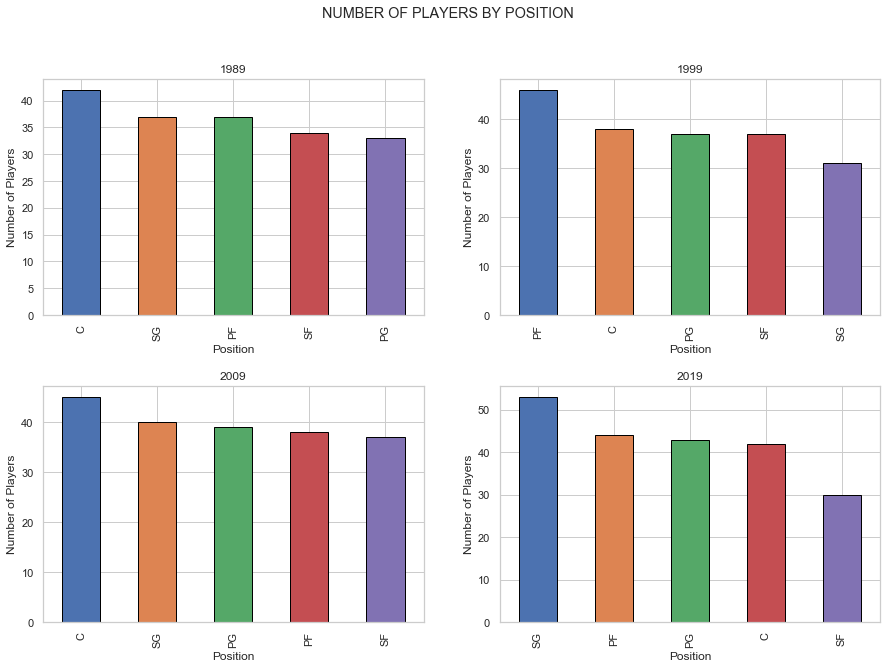

In [175]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10));
list_of_df[0]['Pos'].value_counts().plot.bar(ax = ax1, edgecolor='black');
list_of_df[1]['Pos'].value_counts().plot.bar(ax = ax2, edgecolor='black');
list_of_df[2]['Pos'].value_counts().plot.bar(ax = ax3, edgecolor='black');
list_of_df[3]['Pos'].value_counts().plot.bar(ax = ax4, edgecolor='black');
fig.suptitle('NUMBER OF PLAYERS BY POSITION')
ax1.set_title('1989')
ax1.set_xlabel('Position')
ax1.set_ylabel('Number of Players')
ax2.set_title('1999')
ax2.set_xlabel('Position')
ax2.set_ylabel('Number of Players')
ax3.set_title('2009')
ax3.set_xlabel('Position')
ax3.set_ylabel('Number of Players')
ax4.set_title('2019')
ax4.set_xlabel('Position')
ax4.set_ylabel('Number of Players')
fig.subplots_adjust(wspace=0.2, hspace=0.3)

From the plot above, we can see that Shooting Guards have dominated the teams in the year 2019. Also, while Point Guards have the least number in 1989, it has climbed to become the third most played role in the other years. We have also seen a decline in the number of Centers which has placed only fourth in the year 2019, despite being the most played role in the year 2009.

#### POINTS PER POSITION

Let us now try to look at the points per game per playing position.

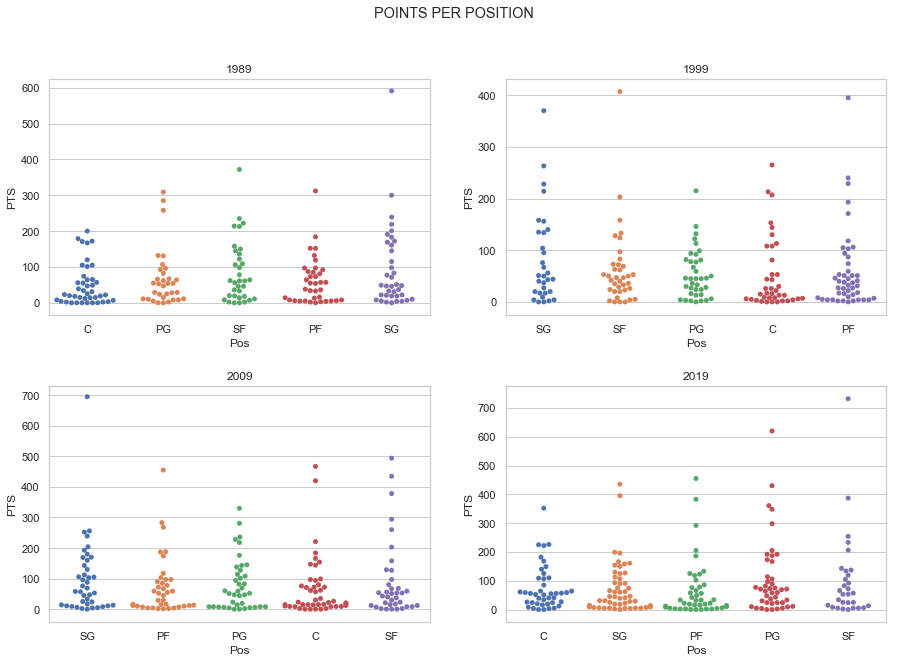

In [183]:
fig, ax = plt.subplots(2,2, figsize=(15, 10));
sns.swarmplot(x='Pos', 
              y=list_of_df[0]['PTS'].astype(float), 
              data = list_of_df[0],ax=ax[0,0]).set_title('1989');
sns.swarmplot(x='Pos', 
              y=list_of_df[1]['PTS'].astype(float), 
              data = list_of_df[1],ax=ax[0,1]).set_title('1999');
sns.swarmplot(x='Pos', 
              y=list_of_df[2]['PTS'].astype(float), 
              data = list_of_df[2],ax=ax[1,0]).set_title('2009');
sns.swarmplot(x='Pos', 
              y=list_of_df[3]['PTS'].astype(float), 
              data = list_of_df[3],ax=ax[1,1]).set_title('2019');
fig.suptitle('POINTS PER POSITION');
fig.subplots_adjust(wspace=0.2, hspace=0.3);

From the swarmplots above, we can observe the following:
- There are outlier players that have contributed very high points per game. Among these are one shooting guard in 1989, one small forward in 1999, one shooting guard in 2009 and one small forward in 2019.
- In general, the player position that contributes the most points varies per year.

#### MINUTES PER GAME

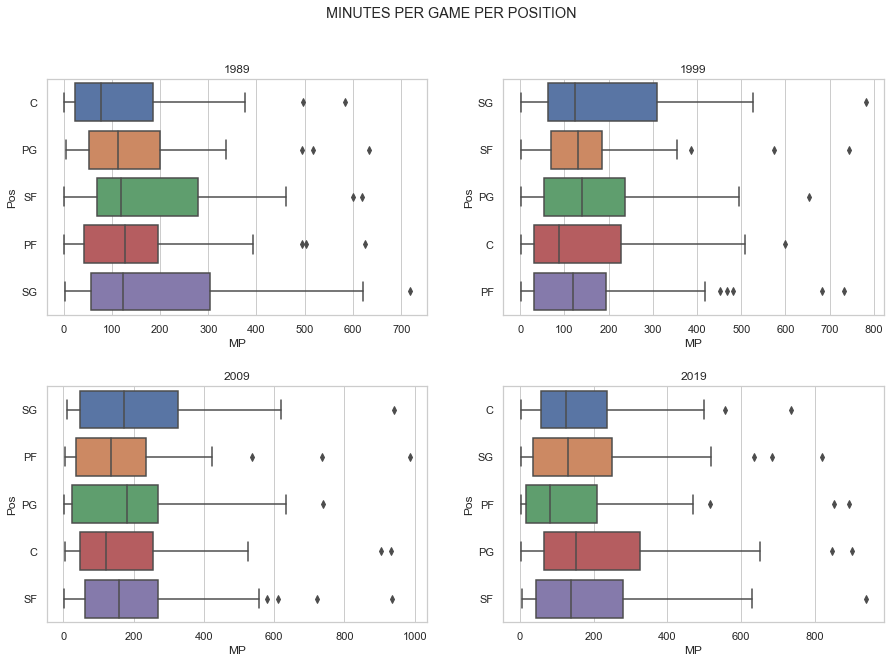

In [193]:
fig, ax = plt.subplots(2,2, figsize=(15, 10));
sns.boxplot(list_of_df[0]['MP'].astype(float), 'Pos', data=list_of_df[0], ax=ax[0,0]).set_title('1989')
sns.boxplot(list_of_df[1]['MP'].astype(float), 'Pos', data=list_of_df[1], ax=ax[0,1]).set_title('1999')
sns.boxplot(list_of_df[2]['MP'].astype(float), 'Pos', data=list_of_df[2], ax=ax[1,0]).set_title('2009')
sns.boxplot(list_of_df[3]['MP'].astype(float), 'Pos', data=list_of_df[3], ax=ax[1,1]).set_title('2019')
fig.suptitle('MINUTES PER GAME PER POSITION');
fig.subplots_adjust(wspace=0.2, hspace=0.3);

In 1989, it is the Power Forward that has the highest median minutes played while Center had the lowest. In 1999, the Point Guards recorded a higher median minutes played compared to the Power Forward. In 2009, the Point Guards had the highest median minutes played and Center had the lowest. Interestingly, in 2019, Power Forward recorded the lowest median minutes played and Point Guards recorded the highest median.

## Models

### 1. Normalizing the data
We want to normalize our dataset. By using StandardScaler, we are removing the mean and scaling to unit variance. This will help ensure that features with high values will not have a greater impact on the similarity comparison than the features with the low values. Below, we will first do the clustering using the 2019 data. We will be comparing the results of the clusters formed here to the clusters formed using the 1989, 1999 and 2009 data.

In [223]:
df_stats = list_of_df[3].iloc[:,5:]
df_stats['Age'] = list_of_df[3]['Age']
df_stats = df_stats.apply(pd.to_numeric)
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(df_stats)
X

array([[-0.57246124,  0.19197371, -0.1445399 , ..., -0.23371086,
        -0.22325361, -0.40925645],
       [-0.22620794,  0.53112726,  0.28526356, ...,  0.21569233,
         0.52043427,  1.59102869],
       [-1.09184119, -0.65591017, -0.87773402, ..., -0.96399104,
        -0.68232021, -0.90932774],
       ...,
       [-0.74558789, -0.65591017, -0.87773402, ..., -0.79546484,
        -0.69150154, -0.90932774],
       [-0.74558789,  0.02239693, -0.29117872, ..., -0.40223705,
        -0.37933625,  0.84092176],
       [-0.74558789, -0.14717984, -0.75132124, ..., -0.68311404,
        -0.58132555, -1.40939902]])

### 2. Dimensionality Reduction: Principal Component Analysis (PCA)
This step is necessary so that our methodology will not be affected by the curse of dimensionalities. Here, we will be using PCA or the Principal Component Analysis to reduce the dimensionality of our dataset. In this process, we are getting only the 2 main principal components in our data. This means that we are trying to explain all the features our dataset has into these representative principal components.

In [224]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pcaComponents = pca.fit_transform(X)
pca.explained_variance_ratio_.sum() 

0.8281368818370006

Using 4 components, we can see that we have a cumulative explained variance ratio of about 82%. In keeping 4 components, we are taking account for roughly 82% of the variance in the data.

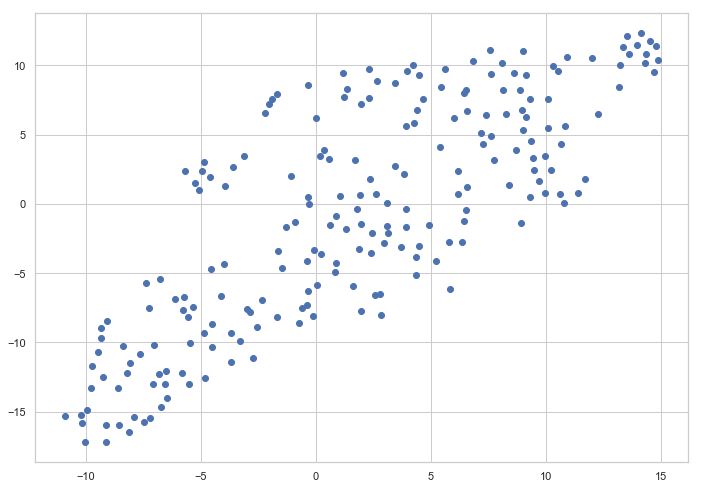

In [225]:
X = pcaComponents
X_new = TSNE(random_state=1337).fit_transform(X)
plt.scatter(X_new[:,0], X_new[:,1]);

### 3. Clustering: K-Means
In this section, we will try to cluster our data using the K-Means algorithm. In this clustering method, the model divides the data into K clusters and each cluster is represented by its centroid or center, that is the mean of the players in that cluster.

Using K-Means, we looped through k-values from 2 to 11, which we will further test through the internal validation metrics below. We will be loading some important functions below to be used for our validation.

In [226]:
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    total_a = 0.0
    ctr_a = 0
    total_b = 0.0
    ctr_b = 0
    np.random.seed(11)
    for i, j in np.random.randint(low=0, high=len(y), size=[r,2]):
        if i == j:
            continue
        elif y[i] == y[j]:
            total_a += dist(X[i], X[j])
            ctr_a += 1
        else:
            total_b += dist(X[i], X[j])
            ctr_b += 1
    res_a = total_a / ctr_a
    res_b = total_b / ctr_b
    res = float(res_a / res_b)
    return res

In [227]:
def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    scs = []
    iidrs = []
    chs = []
    ys = []
    inertias = []
    amis = []
    ars = []
    ps = []

    for i in range(k_start, k_stop+1):

        new_clusterer = clusterer
        new_clusterer.n_clusters = i

        y = new_clusterer.fit_predict(X)

        ys.append(y)
        iidrs.append(intra_to_inter(X, y, dist=euclidean, r=50))
        scs.append(silhouette_score(X, y))
        chs.append(calinski_harabaz_score(X, y))

        inertias.append(new_clusterer.inertia_)

        if actual is not None:
            amis.append(adjusted_mutual_info_score(
                actual, y, average_method='arithmetic'))
            ars.append(adjusted_rand_score(actual, y))
            ps.append(purity(actual, y))

    ret = {'scs': scs,
           'iidrs': iidrs,
           'chs': chs,
           'ys': ys,
           'inertias': inertias
           }

    if actual is not None:
        ret.update({'amis': amis,
                    'ars': ars,
                    'ps': ps})
    return ret

In [229]:
def plot_clusters(X, ys):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True, 
                           figsize=(7,4), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k,y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k%k_mid-2].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[0][k%k_mid-2].set_title('$k=%d$'%k)
        else:
            ax[1][k%k_mid].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[1][k%k_mid].set_title('$k=%d$'%k)
    return ax

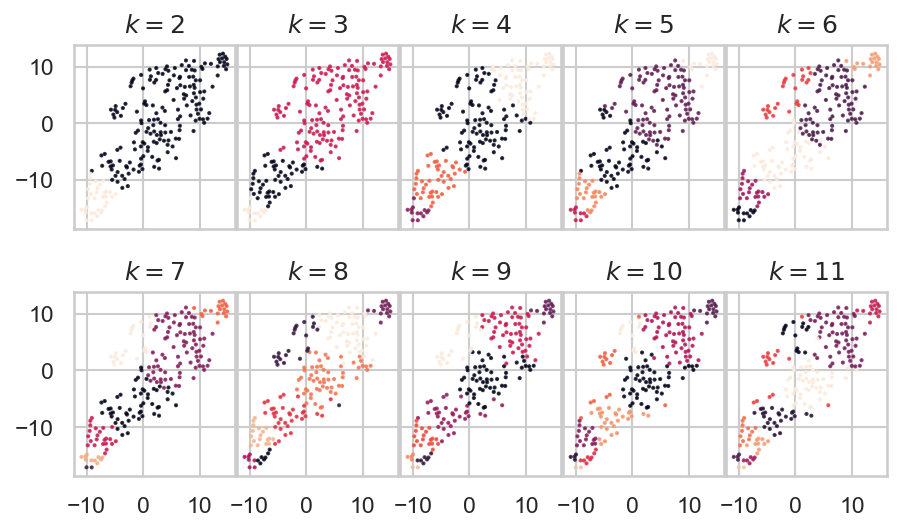

In [230]:
res = cluster_range(X, KMeans(random_state=713), 2, 11)
plot_clusters(X_new, res['ys']);

To help us identify the optimal number of $k$ clusters, we will use the following internal cluster validation metrics:

- **Sum of Squares Distances to centroids (SSE):** This measure corresponds to the sum of squares distances to the representative points. The smaller the distances suggest there is a better clustering and that the data points are more clumped. 
- **Calinski-Harabasz index (CH):** This is also known as the Variance Ratio Criterion which is the ratio of the between-clusters dispersion mean and the within-cluster dispersion. The higher the value of this measure, the more defined the clusters are.
- **Intracluster to intercluster distance ratio (IIDR):** This is the ratio of the average distance of pairs that belong to the same cluster, and the average distance of pairs that belong to different cluster. Small values of this measure indicate better clustering behavior. 
- **Silhouette coefficient (SCS):** Values here range from -1 to 1 where 1 means there is good separation among clusters and -1 indicates some level of intersection between clusters.

In general, we want to get small values for SSE and IIDR and high values for SCS and CH to ensure a good clustering.

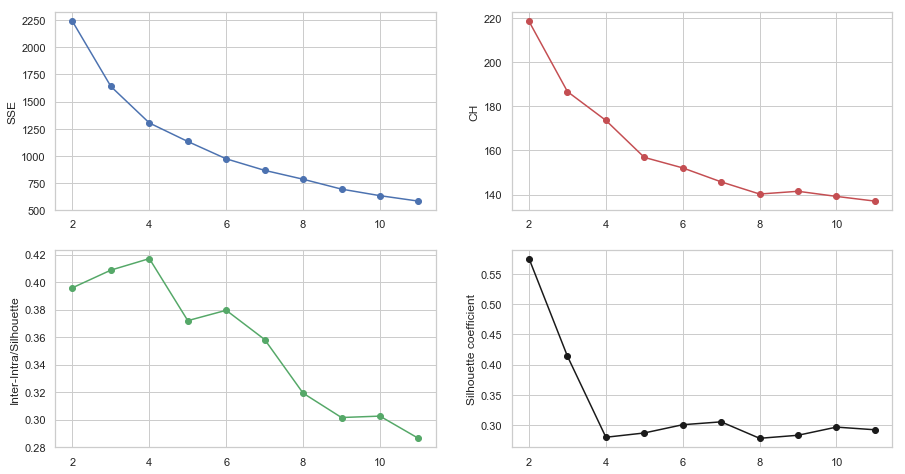

In [232]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 8))
ks = np.arange(2, len(res['inertias'])+2)
ax1.plot(ks, res['inertias'], '-o', label='SSE')
ax1.set_ylabel('SSE')
ax2.plot(ks, res['chs'], '-ro', label='CH')
ax2.set_ylabel('CH')
ax3.plot(ks, res['iidrs'], '-go', label='Inter-intra')
ax4.plot(ks, res['scs'], '-ko', label='Silhouette coefficient')
ax3.set_ylabel('Inter-Intra/Silhouette')
ax4.set_ylabel('Silhouette coefficient')
lines2, labels2 = ax2.get_legend_handles_labels()

We have chosen k = 3 as our number of clusters. It is at this k-value where the most drop in SSE happened. The CH value is also relatively high at this point. Despite getting a relatively high inter-intra value, the Silhoutte coefficient at this point is still fairly high as compared to higher values of k.

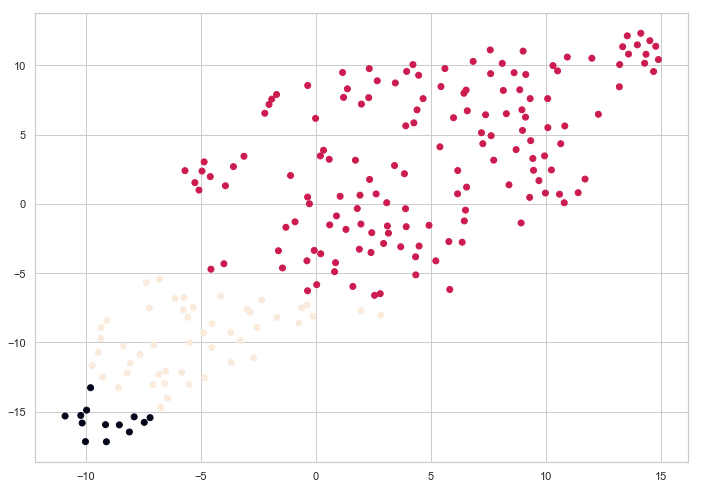

In [235]:
kmeans = KMeans(n_clusters=3, random_state=1337)
y_predict = kmeans.fit_predict(X)
plt.scatter(X_new[:,0], X_new[:,1], c=y_predict);

A new dataframe `df_merge` is made from merging the tags per row with the statistical data along with the prediction labels based on the clustering.

In [237]:
df_tags=list_of_df[3].iloc[:,1:5]
df_tags=df_tags.drop(['Age'], axis=1)
df_stats['Pred']=y_predict
df_merge = pd.concat([df_stats, df_tags], axis=1)
df_merge.head()

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,STL,BLK,TOV,PF,PTS,Age,Pred,Player,Pos,Tm
0,5,5,159,28,42,0.667,0,1,0.000,28,...,5,5,9,13,59,25,1,Steven Adams,C,OKC
1,7,7,244,55,121,0.455,3,11,0.273,52,...,5,7,7,21,140,33,2,LaMarcus Aldridge,C,SAS
2,2,0,14,2,7,0.286,0,3,0.000,2,...,0,0,0,0,9,23,1,Grayson Allen,SG,UTA
3,5,5,110,19,32,0.594,0,0,0.000,19,...,3,3,8,13,55,20,1,Jarrett Allen,C,BRK
4,16,16,399,38,109,0.349,15,51,0.294,23,...,9,10,16,34,118,28,2,Al-Farouq Aminu,PF,POR


Below, we will see players belonging to Cluster 1. Doing some spot analysis, it is quite obvious that the top players belong to one cluster, and the other two are based on performances as well. Results of this cluster and the other clusters will be discussed in detail below.

In [243]:
df_merge[df_merge['Pred']==0]

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,STL,BLK,TOV,PF,PTS,Age,Pred,Player,Pos,Tm
5,15,15,514,129,262,0.492,18,55,0.327,111,...,17,30,50,48,383,24,0,Giannis Antetokounmpo,PF,MIL
41,22,22,846,190,431,0.441,92,244,0.377,98,...,24,4,66,68,620,30,0,Stephen Curry,PG,GSW
47,12,12,442,125,243,0.514,35,80,0.438,90,...,13,12,43,38,387,30,0,Kevin Durant,SF,GSW
63,24,24,735,76,180,0.422,34,89,0.382,42,...,21,26,21,84,226,34,0,Marc Gasol,C,TOR
74,22,22,851,114,229,0.498,13,57,0.228,101,...,32,33,83,85,292,28,0,Draymond Green,PF,GSW
78,11,11,424,109,264,0.413,48,137,0.350,61,...,24,10,51,41,348,29,0,James Harden,PG,HOU
104,14,14,557,132,261,0.506,22,56,0.393,110,...,16,13,36,54,352,23,0,Nikola Jokić,C,DEN
115,24,24,939,243,496,0.490,55,145,0.379,188,...,40,17,74,56,732,27,0,Kawhi Leonard,SF,TOR
119,16,16,650,138,330,0.418,59,158,0.373,79,...,27,5,60,40,430,28,0,Damian Lillard,PG,POR
124,24,24,901,122,278,0.439,52,145,0.359,70,...,31,7,53,96,361,32,0,Kyle Lowry,PG,TOR


## Results, Recommendations and Insights

This dataset was clustered into three, indicative of the performances of the players for the 2018-2019 playoffs regardless of whatever team the player belongs to, namely: **`the Standouts`, `the Regulars`, and `the Mediocres`**.

The clusters have shown the segregations of players by performance regardless of the team they play for. The NBA Playoffs have a format of elimination so a standout player in a team that gets eliminated early would not play as much as player in a team that have played until the finals. Therefore new features have been made to reflect the contribution of the player to winning an individual game regardless of how many games he has played in. These are total games started per total number of games (GS%), and total points per total number of games (PPG). There are only 13 players in this cluster.


**`The Standouts`** - Just by looking at the name value, it is obvious that players in this cluster are the leading scorers of their teams. Having the players Steph Curry and Kahwi Leonard, the players in this cluster have an average 23.24 points per game. They have a GS% of 1, meaning they are consistently in the starting five of each of their teams.

**`The Regulars`** - These are mid-tier players, who score less that the Standouts' 12.49 points per game on playoffs average, and therefore they have a lower percentage of games started (63.38%). There are 49 players in this cluster.

**`The Mediocres`** - The largest cluster of the four at 149 data points, these are the players who do not stand out in performances and have the least contribution to their respective team (5.96 points per game). They have the least games started at 25.92%

Visually, internal validation metrics used for determining the clusters were not as clear-cut, as such, it is recommended that other clustering methods may also be explored. Agglomerative clustering were also explored, as seen in the appendix, but for this report, results using K-Means are more intuitive.

### Time Analysis: How does the clusters in 2019 compare to 1989, 1999 and 2009?
This study will note the differences of the nature of how the playoffs are played throughout the years. This will be done by repeating the clustering method for four different years 10 years apart: 2019, 2009, 1999 and 1989. The statistical data of the **top cluster of players each season** will be compared to each other since these are the players that matter the most in doing well. The data resulting from the clustering of playoffs of different years were stored in .csv files and will be analyzed to note the changes per year.

The data for each NBA season was saved into separate .csv files. One dataframe was made for the data of each year and are loaded below.

In [244]:
df_2019 = pd.read_csv('nba_2019.csv').drop(['Unnamed: 0'], axis=1)
df_2009 = pd.read_csv('nba_2009.csv').drop(['Unnamed: 0'], axis=1)
df_1999 = pd.read_csv('nba_1999.csv').drop(['Unnamed: 0'], axis=1)
df_1989 = pd.read_csv('nba_1989.csv').drop(['Unnamed: 0'], axis=1)

The statistics standout player cluster for each season were grouped in a dataframe where the averages of features relating to an individual player's contribution the the playoffs can be  anlayzed against the other seasons.

In [247]:
s4=df_2019.groupby('Pred').mean()[['FG','FGA','FG%','3P','3PA','3P%','TRB','AST','STL','BLK','PTS']].iloc[0]
s3=df_2009.groupby('Pred').mean()[['FG','FGA','FG%','3P','3PA','3P%','TRB','AST','STL','BLK','PTS']].iloc[0]
s2=df_1999.groupby('Pred').mean()[['FG','FGA','FG%','3P','3PA','3P%','TRB','AST','STL','BLK','PTS']].iloc[2]
s1=df_1989.groupby('Pred').mean()[['FG','FGA','FG%','3P','3PA','3P%','TRB','AST','STL','BLK','PTS']].iloc[1]
df_4seasons=pd.concat([s1, s2,s3,s4], axis=1)
df_4seasons.columns=['1989','1999','2009','2019']
df_4seasons

,1989,1999,2009,2019
FG,71.853659,83.200000,136.583333,144.307692
FGA,150.073171,176.800000,286.750000,312.846154
FG%,0.481585,0.482067,0.479250,0.461462
3P,6.365854,2.666667,26.333333,44.076923
3PA,19.536585,11.000000,68.333333,118.846154
3P%,0.222829,0.089800,0.321083,0.363154
TRB,74.707317,112.333333,147.333333,135.153846
AST,44.390244,34.000000,84.666667,94.769231
STL,12.780488,15.200000,25.916667,23.923077
BLK,7.487805,17.200000,18.083333,15.307692


### Insight 1
Looking at certain features representing the standouts compiled averages per playoff seasons, some progressively got higher from 1989 to 2019, and some stayed the same.

The field goals (FG) and points (PTS) moved progressively higher but the field goal percentages (FG%) stayed around the same level. This seems to indicate that teams became more dependent on their top players from the 80's to the current era.

This is indicative of the "Super-Team Era" the NBA is now experiencing. The present environment the NBA revolves around the richest teams using their resources to pool the best players in the league specifically to win a championship for their city.

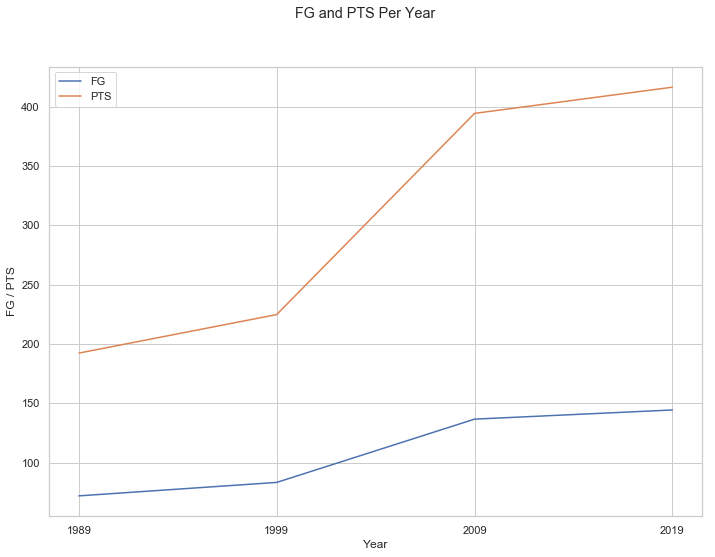

In [294]:
dfplot1 = df_4seasons.drop(['FGA', 'FG%', '3P', '3PA', '3P%', 'TRB', 'AST', 'STL', 'BLK'], axis=0).T
dfplot1.plot();
plt.xticks(np.arange(4), ('1989', '1999', '2009', '2019'));
plt.xlabel('Year')
plt.ylabel('FG / PTS')
plt.suptitle('FG and PTS Per Year');

### Insight 2
Looking at the 3P, 3P and 3P% statistics, there was a huge jump from 1999 to 2009, and from 2009 and 2019. This is indicative of the three-point shooter based strategy . The most successful team as of late is the Golden State Warriors, known for their players like Stephen Curry and Klay Thompson, known for being able to throw and land three-pointers on the fly.

### Insight 3
There are also about double the average number of assists the top players complete in 2019 compared to 30 years ago. This is indicative of the number of European players making their mark in the NBA. The style of playing imported players from the Balkans or the former Soviet regions involves a lot passing, and the overall structure of the game of current NBA has changed because of this.

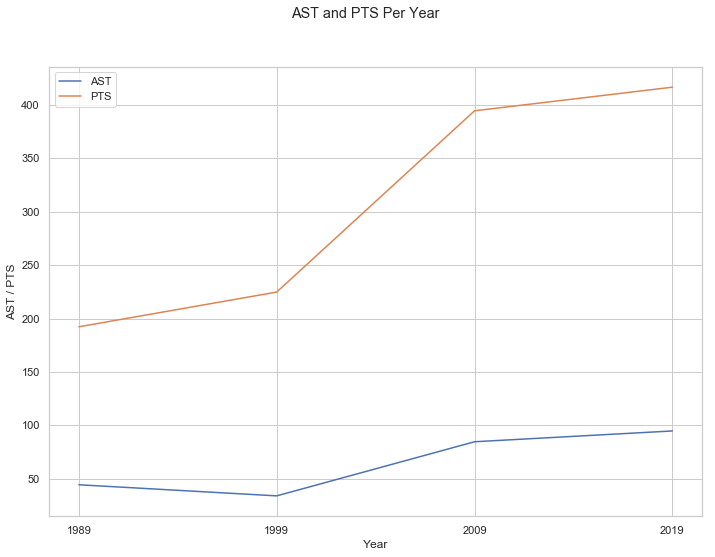

In [297]:
dfplot2 = df_4seasons.drop(['FGA', 'FG%', 'FG', '3P', '3PA', '3P%', 'TRB', 'STL', 'BLK'], axis=0).T
dfplot2.plot();
plt.xticks(np.arange(4), ('1989', '1999', '2009', '2019'));
plt.xlabel('Year')
plt.ylabel('AST / PTS')
plt.suptitle('AST and PTS Per Year');

## References
1. Alis, Christian (2019). Representative-based clustering Notebook.
2. Alis, Christian (2019). Hierarchical-based clustering Notebook.
3. https://github.com/adrianromano/2017-2018-NBA-Regular-Season-Analysis/blob/master/Analysis%20of%202017-2018%20NBA%20Regular%20Season.ipynb
4. https://bleacherreport.com/articles/2644198-despite-nbas-efforts-era-of-the-superteam-has-made-finals-a-yearly-rerun
5. https://www.theringer.com/nba/2019/5/1/18524629/nikola-jokic-2019-playoffs 
6. https://www.total-croatia-news.com/sport/26423-croatian-basketball-players-dominate-nba-last-night-after-scoring-a-collective-58-points

## Acknowledgements

1. Prof. Alis and Prof. Ed
2. Prof. Legara
3. The rest of MSDS faculty and staff

## Appendix: Other Clustering Methods Explored

For this report, we have also explored different agglomerative clustering methods. Using Ward's, Average, Complete and Single Linkage methods, we have determined 2 to be the optimal number of clusters. However, for this report, we have pursued using K-Means as the results there are more intuitive and interesting to explore.

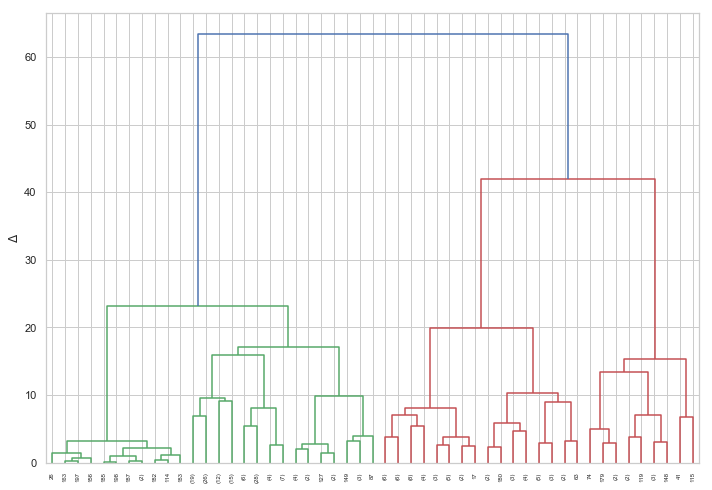

In [248]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
Z_pop_ward = linkage(X, method='ward', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z_pop_ward, ax=ax, p=5, truncate_mode='level')
ax.set_ylabel(r'$\Delta$');

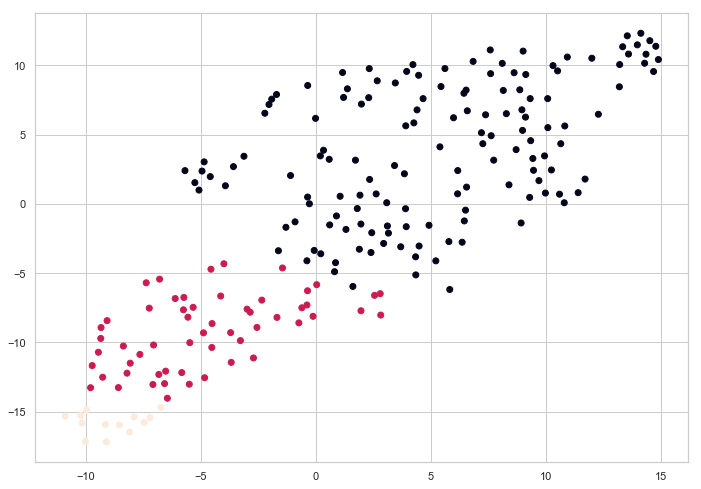

In [249]:
y_pop_ward = fcluster(Z_pop_ward, t=25, criterion='distance')
plt.scatter(X_new[:,0], X_new[:,1], c=y_pop_ward);

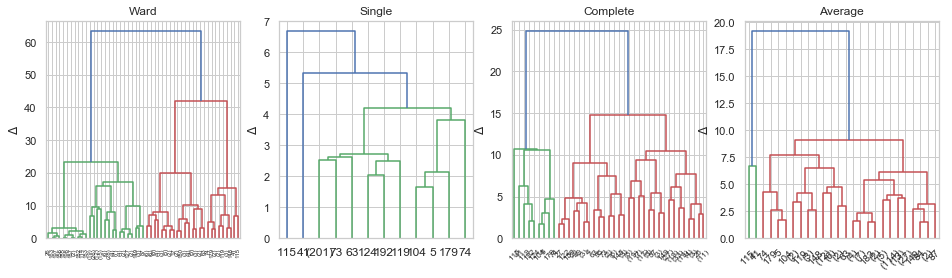

In [250]:
Z_pop_ward = linkage(X, method='ward', optimal_ordering=True)
Z_pop_single = linkage(X, method='single', optimal_ordering=True)
Z_pop_complete = linkage(X, method='complete', optimal_ordering=True)
Z_pop_average = linkage(X, method='average', optimal_ordering=True)

fig, ax = plt.subplots(1,4, figsize=(16,4))
dn = dendrogram(Z_pop_ward, ax=ax[0], p=5, truncate_mode='level')
ax[0].title.set_text('Ward')
ax[0].set_ylabel(r'$\Delta$');
dn = dendrogram(Z_pop_single, ax=ax[1], p=5, truncate_mode='level')
ax[1].title.set_text('Single')
ax[1].set_ylabel(r'$\Delta$');
dn = dendrogram(Z_pop_complete, ax=ax[2], p=5, truncate_mode='level')
ax[2].title.set_text('Complete')
ax[2].set_ylabel(r'$\Delta$');
dn = dendrogram(Z_pop_average, ax=ax[3], p=5, truncate_mode='level')
ax[3].title.set_text('Average')
ax[3].set_ylabel(r'$\Delta$');

In [251]:
def distance_(type_):
    """Returns number of clusters given agglomerative clustering method"""
    Z_pop_ward = linkage(X, method=type_, optimal_ordering=True)
    last = Z_pop_ward[-10:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    plt.plot(idxs, last_rev, label='Distance')

    acceleration = np.diff(last, 2)
    acceleration_rev = acceleration[::-1]
    plt.plot(idxs[:-2] + 1, acceleration_rev, label='Drop in Distance')
    k = acceleration_rev.argmax() + 2
    plt.title('Elbow Method Variation for Hierarchical Clustering')
    plt.ylabel('Distance')
    plt.xlabel('Number of Clusters')
    print('Ideal number of clusters:', k)
    plt.legend()

    return acceleration_rev.max()

Ideal number of clusters: 3


15.424150809632152

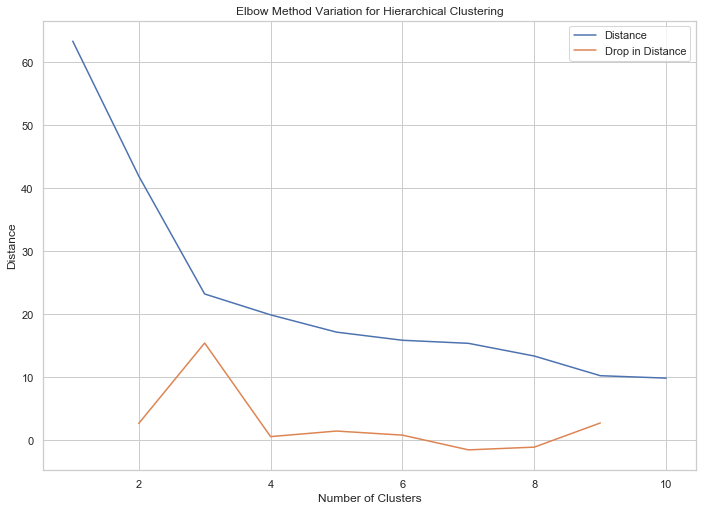

In [252]:
distance_('ward')

Ideal number of clusters: 5


1.002145243528214

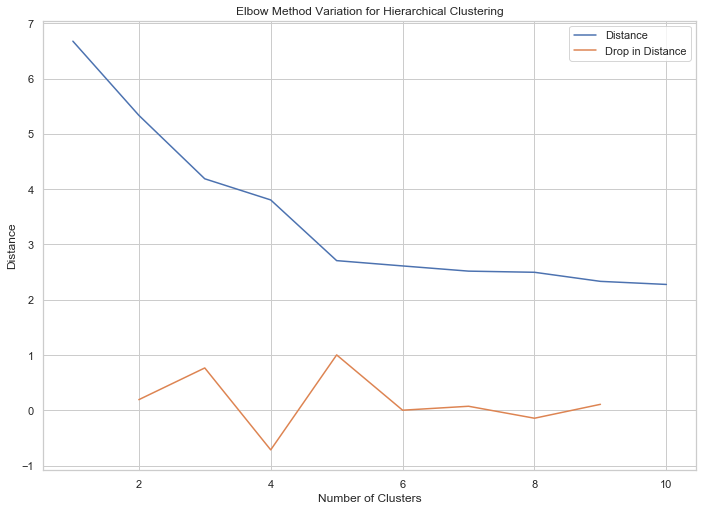

In [253]:
distance_('single')

Ideal number of clusters: 2


5.976076123840404

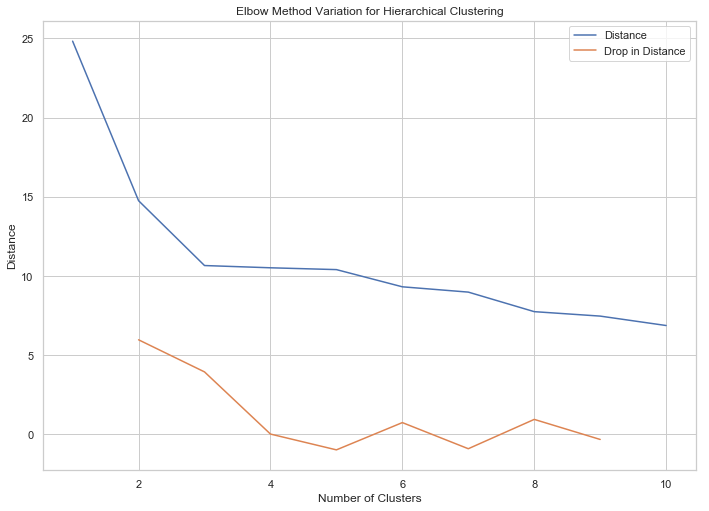

In [254]:
distance_('complete')

Ideal number of clusters: 2


8.695890475116823

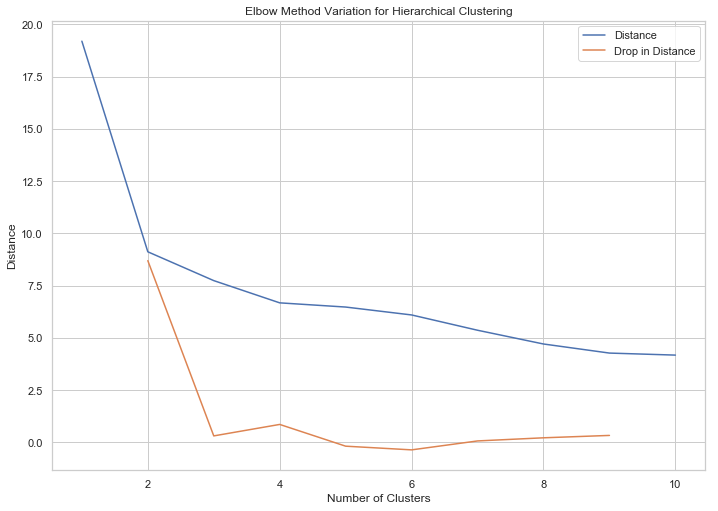

In [255]:
distance_('average')